In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import imghdr
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [2]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

In [3]:
data_dir = '/kaggle/input/book-covers-dataset'
dataset_folder = os.path.join(data_dir, 'book-covers/')

In [4]:
# how many book topics is
len(os.listdir(os.path.join(data_dir, 'book-covers')))

33

<font size='5'>Show first book cover</font>

In [5]:
img = cv2.imread(os.path.join(data_dir, 'book-covers', 'Biography', '0000001.jpg'))

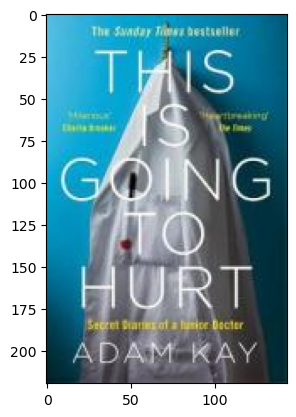

In [6]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [7]:
# Download pretrained model
model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                        pooling='max')

94765736/94765736 [==============================] - 1s 0us/step


In [8]:
# show model architecture
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [9]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img, verbose=0)    # don't show progress bar
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [10]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
    return file_list

In [11]:
# # don't enough RAM for that
# # path to the your datasets
# root_dir = '/kaggle/input/book-covers-dataset'
# filenames = sorted(get_file_list(root_dir));

# feature_list = [];
# for i in tqdm_notebook(range(len(filenames))):
#     feature_list.append(extract_features(filenames[i], model));

<font size='5'>Eatch photos contains 2048-element array which is the activations of the ~~last fully-connected layer~~ global pooling layer.
Our expectation is that the max_pool activations form a very good representation of the image, such that similar images should produce similar activations. In other words, the max_pool activations of two images which have similar content should be very close to each other. We can exploit this to do information retrieval.</font>

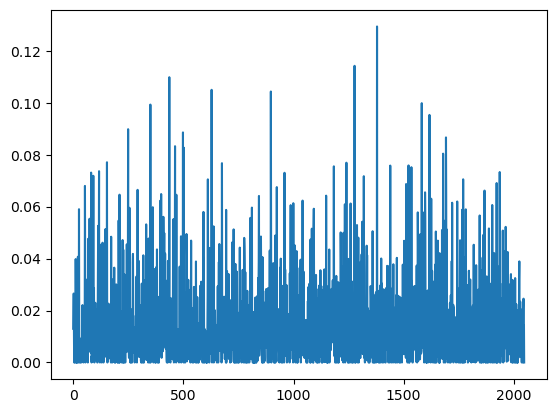

In [12]:
len(extract_features('/kaggle/input/book-covers-dataset/book-covers/Art-Photography/0000003.jpg', model))
plt.plot(extract_features('/kaggle/input/book-covers-dataset/book-covers/Art-Photography/0000002.jpg', model))

<font size='5'>Since we don't have much RAM, I will use split on batches technic.
Splitting image datasets into batches is necessary when training machine learning models on large datasets. By splitting the dataset, we divide it into smaller subsets or "batches" of images that can be processed by the machine learning algorithm more efficiently. This approach enables faster training, as the algorithm doesn't have to load and process the entire dataset at once. Instead, it loads one batch at a time, performs calculations, updates the weights, and then moves on to the next batch. </font>

In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

class_names = sorted(os.listdir(dataset_folder))

generator = datagen.flow_from_directory(
    dataset_folder,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_batches = int(np.ceil(generator.samples / batch_size))


Found 32581 images belonging to 33 classes.


In [14]:
num_batches

1019

In [15]:
32581/32

1018.15625

In [16]:
feature_list = []
for i in range(num_batches):
    batch_x, batch_y = generator.next()
    
    batch_filenames = generator.filenames[i * generator.batch_size : (i + 1) * generator.batch_size]
    
    for j in range(len(batch_filenames)):
        feature_list.append(extract_features(dataset_folder+batch_filenames[j], model))

In [17]:
len(feature_list[0])

2048

In [18]:
filenames = sorted(get_file_list(dataset_folder))
num_images = len(filenames)

In [19]:
# save models
pickle.dump(feature_list, open('/kaggle/working//features-book-covers-dataset-resnet.pickle', 'wb'))
pickle.dump(filenames, open('/kaggle/working/filenames-book-covers-dataset.pickle','wb'))

In [20]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)

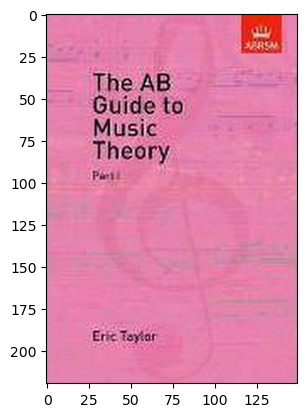

In [21]:
random_index = 75
distances, indices = neighbors.kneighbors([feature_list[random_index]])
plt.imshow(mpimg.imread(filenames[random_index]), interpolation='lanczos')

In [22]:
def classname(str):
    return str.split('/')[-2]


def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]

def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) // columns + 1, columns, i+1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)

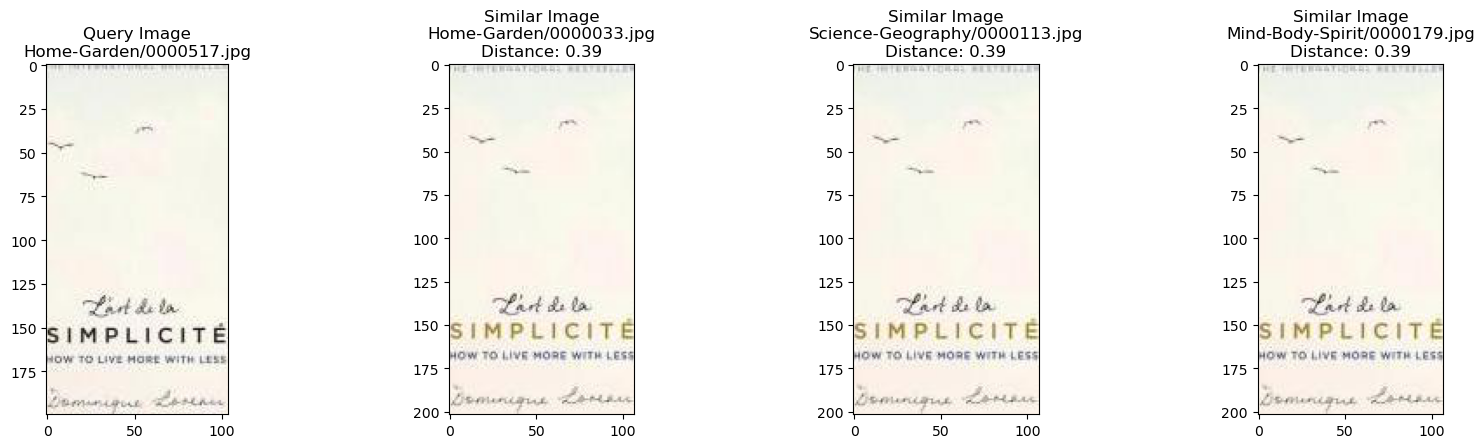

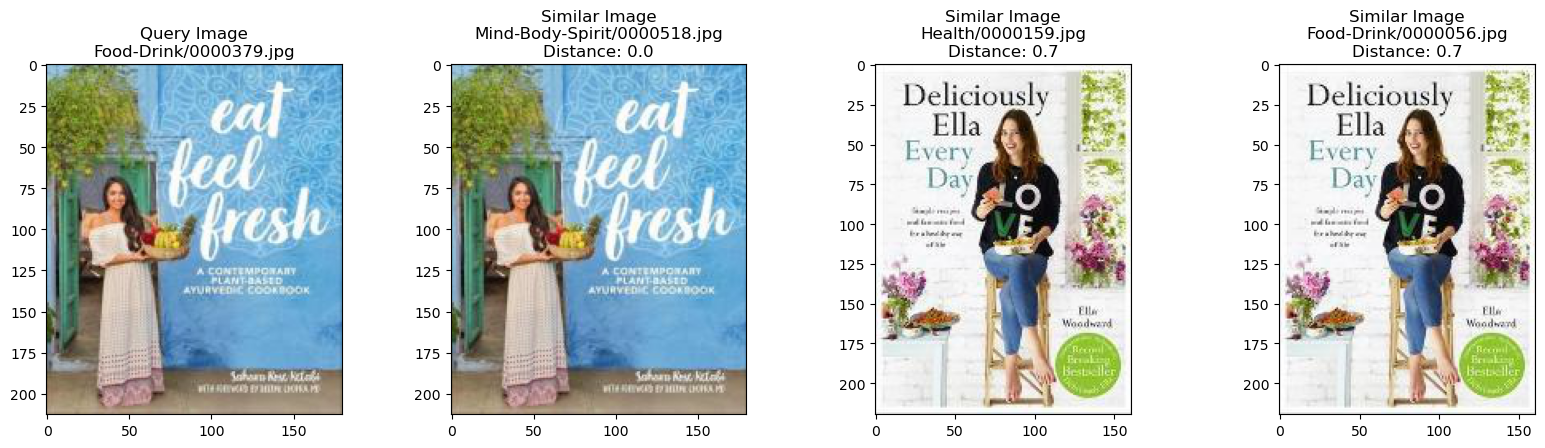

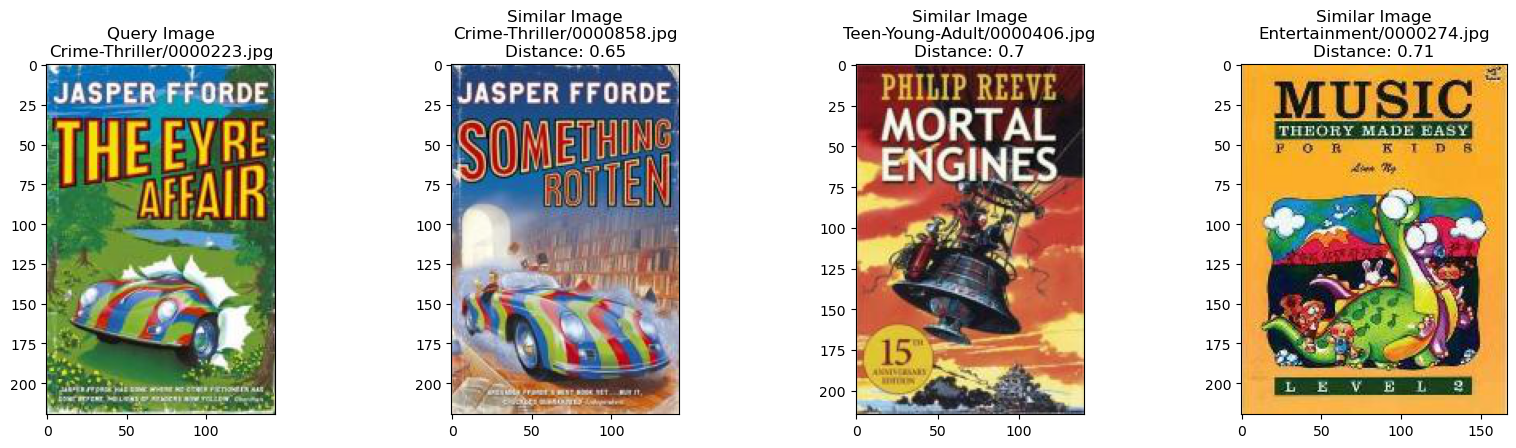

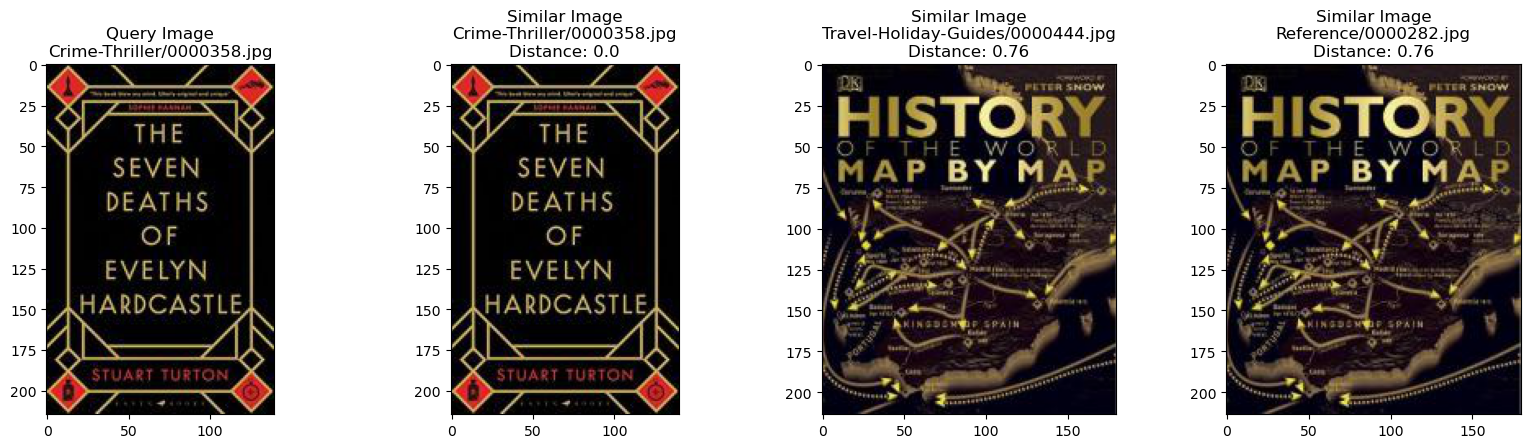

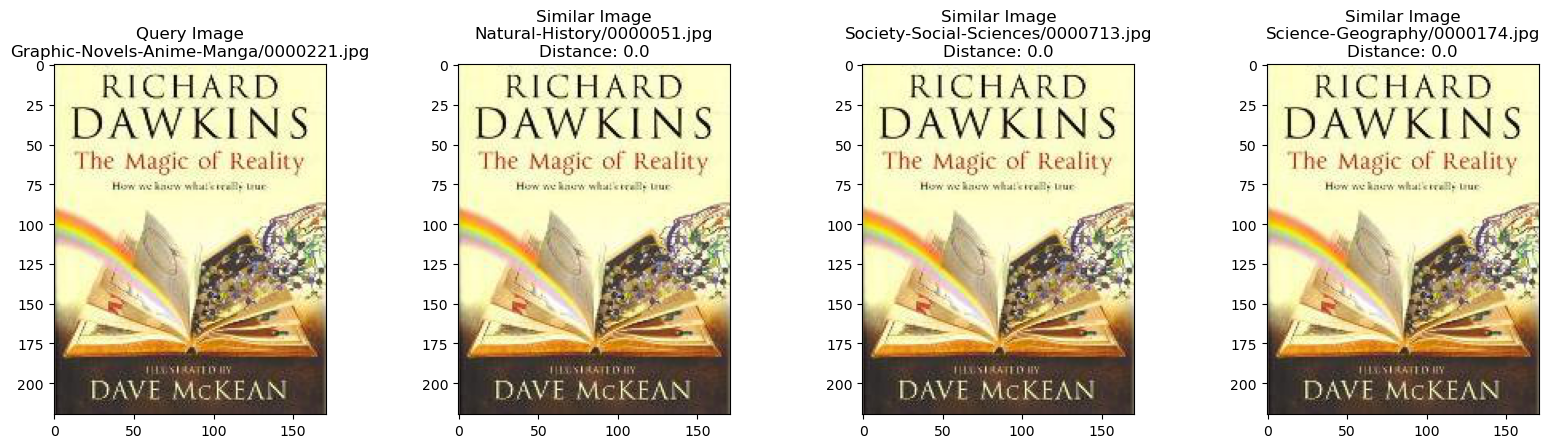

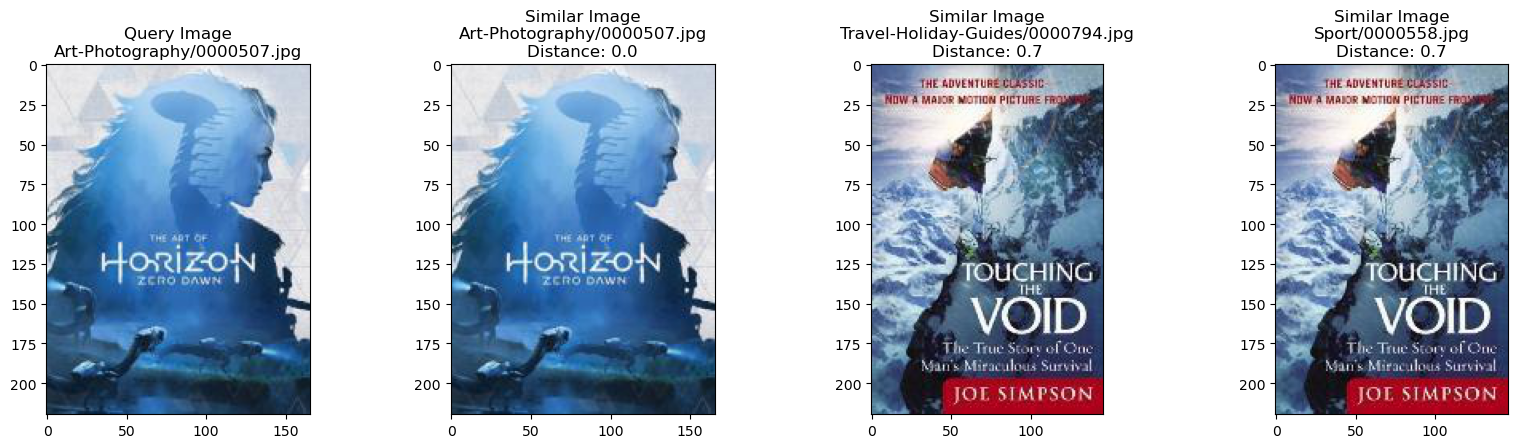

In [23]:
for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors(
        [feature_list[random_image_index]])
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])